### MNIST: Deep Convolutional (DC) Generative Adversarial Network (GAN)

### Install/Load Dependencies

In [ ]:
%%capture
# pip install requierment to run a dependency in code
!pip install "wheel == 0.34.2"

# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from six.moves import urllib # to avoid file download error
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
import time
from google.colab import drive

### Training Parameters


In [ ]:
num_epochs = 10
batch_size = 64
learning_rate = 2e-4
use_gpu = True
img_size = 64
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

### Load MNIST Data

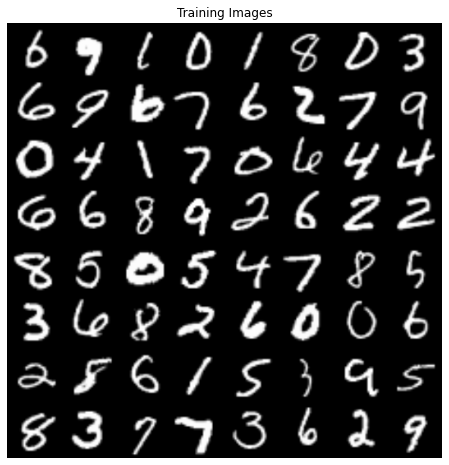

In [ ]:
# define transformer for dataloader
# resize and normalize data for slight performance boost
img_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# file download error quick fix
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Plot some training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

### Custom weight initialization

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

GAN Definition
-----------------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [ ]:
# number of channels (1=gray, 3= RGB colors)
nc = 1
# number/size of latent vector z for the generator input
nz = 100
# size/number of feature maps in generator
ngf = 128
# size/number of feature maps in discriminator
ndf = 128
# define fixed noise to sample images from the latent space of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # input to conv. lay. : length of latent vector z 
        self.deconv1 = nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False)
        self.deconv1_bn = nn.BatchNorm2d(ngf*8)
        # state size: (ngf * 8) x 4 x 4
        self.deconv2 = nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False)
        self.deconv2_bn = nn.BatchNorm2d(ngf*4)
        # state size: (ngf * 4) x 8 x 8
        self.deconv3 = nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False)
        self.deconv3_bn = nn.BatchNorm2d(ngf*2)
        # state size: (ngf * 2) x 16 x 16
        self.deconv4 = nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False)
        self.deconv4_bn = nn.BatchNorm2d(ngf)
        # state size: (ngf) x 32 x 32
        self.deconv5 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)
        # state size: (nc) x 64 x 64

    def forward(self, input):
        x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # input to conv. lay. : (nc) x 64 x 64
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv1_bn = nn.BatchNorm2d(ndf)
        # state size: (ndf) x 32 x 32
        self.conv2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False)
        self.conv2_bn = nn.BatchNorm2d(ndf*2)
        # state size: (ndf * 2) x 16 x 16
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False)
        self.conv3_bn = nn.BatchNorm2d(ndf*4)
        # state size: (ndf * 4) x 8 x 8
        self.conv4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False)
        self.conv4_bn = nn.BatchNorm2d(ndf*8)
        # state size: (ndf * 8) x 4 x 4
        self.conv5 = nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input))
        x = F.leaky_relu(self.conv1_bn(self.conv1(input)), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x
    
generator = Generator()
discriminator = Discriminator()

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02
#generator.apply(weights_init)
#discriminator.apply(weights_init)


device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12654336 and discriminator: 11032320


### Define Storage Location

In [ ]:
# mount google drive for saving checkpoints
drive.mount('/content/drive')

# checkpoint generator file name
gen_save_name = 'mnist_gen.cpt'
# define location to store checkpoints for generator
path_gen = F'/content/drive/My Drive/{gen_save_name}'

# checkpoint discriminator file name
disc_save_name = 'mnist_disc.cpt'
# define location to store checkpoints for discriminator
path_disc = F'/content/drive/My Drive/{disc_save_name}'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train GAN
--------


In [ ]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []
iters = 0

# store generated images 
img_lst = []
# store generated images for gif
img_lst_gif = []

print('Training ...')
for epoch in range(num_epochs):
    # start countine time 
    start_time = time.time() 
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    #for image_batch, _ in tqdm(train_dataloader):
    #for i, data in enumerate(dataloader, 0):
    #for image_batch, _ in train_dataloader: # this is orgiginal
    for image_batch, i in train_dataloader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), nz, 1, 1, device=device)
        fake_image_batch = generator(latent)
        
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
        # every 104 batches give print statement
        if num_batches % 104 == 0 :
            print('Epoch [%d / %d], batch [%d / %d]: average loss generator vs. discrim.: %f vs. %f [%s seconds]' %
          (epoch+1, num_epochs, num_batches, len(train_dataloader), gen_loss_avg[-1], disc_loss_avg[-1], round(time.time() - start_time,3)))
        
        # Save generated image if: 
        # 1) at the first iteration
        # 2) 250 iterations have passed each time
        # 2) final epoch has been reached
        # 3) a full batch of training passed i.e one epoch has passed each time
        elif (iters == 1) or(iters % 250 == 0) or (epoch == num_epochs) or (iters % len(train_dataloader) == 0):
            # turn off gradient descent computation to minimize computation cost
            with torch.no_grad():
                # generate fake image from generator
                fake = generator(fixed_noise).detach().cpu()
            # store image
            img_lst.append(fake)
            # store image for gif
            img_lst_gif.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    # after each epoch print current epoch, generator and discriminator loss and runtime per epoch
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f [%s seconds]'  %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1], round(time.time() - start_time,3)))
    # after each epoch save generator, epochs, loss and images
    print('Generator Checkpoint Saved [%d / %d]' % (epoch + 1, num_epochs))
    torch.save({
            'epoch': epoch,
            'gen_state_dict': generator.state_dict(),
            'optimizer_state_dict': gen_optimizer.state_dict(),
            'gen_loss_avg': gen_loss_avg,
            'img_lst':img_lst,
            'img_lst_gif': img_lst_gif,
            }, path_gen)
    # after each epoch save discriminator, epochs and loss
    print('Discriminator Checkpoint Saved [%d / %d]' % (epoch + 1, num_epochs))
    torch.save({
            'epoch': epoch,
            'disc_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': disc_optimizer.state_dict(),
            'disc_loss_avg': disc_loss_avg,
            }, path_disc)

Training ...
Epoch [1 / 10], batch [104 / 938]: average loss generator vs. discrim.: 946.736664 vs. 1.079738 [18.309 seconds]
Epoch [1 / 10], batch [208 / 938]: average loss generator vs. discrim.: 1966.839642 vs. 1.096527 [36.578 seconds]
Epoch [1 / 10], batch [312 / 938]: average loss generator vs. discrim.: 2422.106419 vs. 56.730045 [54.855 seconds]
Epoch [1 / 10], batch [416 / 938]: average loss generator vs. discrim.: 2922.894842 vs. 80.933029 [73.091 seconds]
Epoch [1 / 10], batch [520 / 938]: average loss generator vs. discrim.: 3648.599913 vs. 81.116461 [91.357 seconds]
Epoch [1 / 10], batch [624 / 938]: average loss generator vs. discrim.: 4442.440013 vs. 81.221131 [109.611 seconds]
Epoch [1 / 10], batch [728 / 938]: average loss generator vs. discrim.: 5310.374019 vs. 81.280035 [127.84 seconds]
Epoch [1 / 10], batch [832 / 938]: average loss generator vs. discrim.: 6243.056322 vs. 81.322693 [146.127 seconds]
Epoch [1 / 10], batch [936 / 938]: average loss generator vs. discri

### Load Generator and Discriminator

In [ ]:
# load models
disc_save_name = 'mnist_disc.cpt'
gen_save_name = 'mnist_gen.cpt'

path_gen = F'/content/drive/My Drive/{gen_save_name}'
path_disc = F'/content/drive/My Drive/{disc_save_name}'

# check whether checkpoint files exist
if os.path.isfile(path_gen) and os.path.isfile(path_disc) == True:
    checkpoint_gen = torch.load(path_gen)
    checkpoint_disc = torch.load(path_disc)

    # neural net is saved on the gpu we send it to the cpu via .to(device)
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    # given the kernel shut done and all variables are lost
    # optimizers need to be initialised again
    gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    generator.load_state_dict(checkpoint_gen['gen_state_dict'])
    discriminator.load_state_dict(checkpoint_disc['disc_state_dict'])
    gen_optimizer.load_state_dict(checkpoint_gen['optimizer_state_dict'])
    disc_optimizer.load_state_dict(checkpoint_disc['optimizer_state_dict'])
    epoch = checkpoint_gen['epoch']
    img_lst = checkpoint_gen['img_lst']
    img_lst_gif = checkpoint_gen['img_lst_gif']
    gen_loss_avg = checkpoint_gen['gen_loss_avg']
    disc_loss_avg = checkpoint_disc['disc_loss_avg']
else: 
    print("Checkpoint files not found or do not exist.")
    print("The neural network may have not been trained yet.")
#model_gen.eval()
# - or -
#model_gen.train()

### Figures

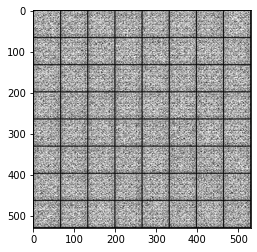

In [ ]:
# plot of generated image
# plot 1st image
plt.imshow(np.transpose(vutils.make_grid(img_lst[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))
# plot 7th image
#plt.imshow(np.transpose(vutils.make_grid(img_lst[6].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

### Gif

In [ ]:
# gif from starting image to last generated image
#%%capture
# if bytes for gif are too big increase limit 
# plt.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.cpu().numpy(),(1,2,0)), animated=True)] for i in img_lst_gif]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

### Training Curve
--------------------

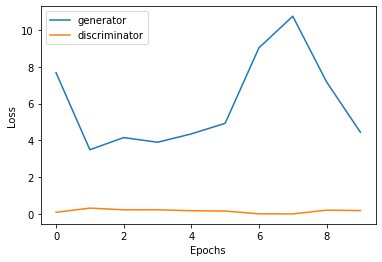

In [ ]:
plt.ion()
fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plot Fake Images

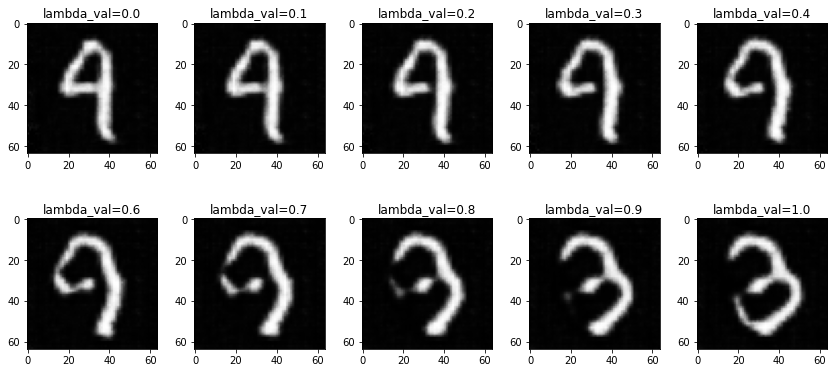

In [ ]:
plt.ion()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, nz, 1, 1, device=device)
latent_2 = torch.randn(1, nz, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

### Plot Real vs. Fake Images

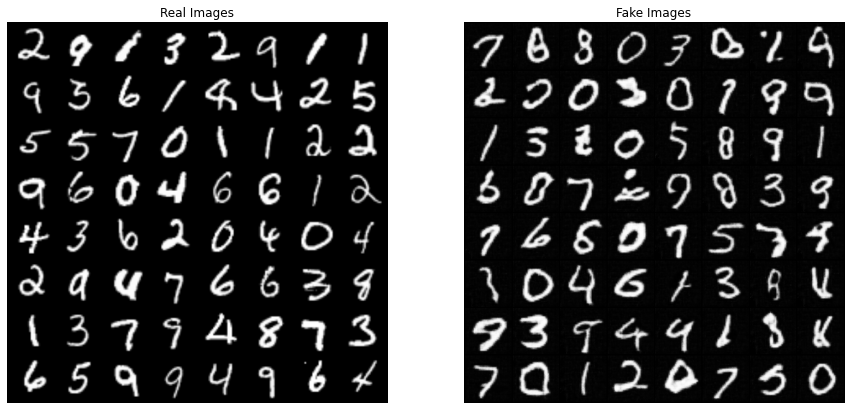

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_lst_gif[-1].cpu().numpy(),(1,2,0)))
plt.show()

### Generate Images

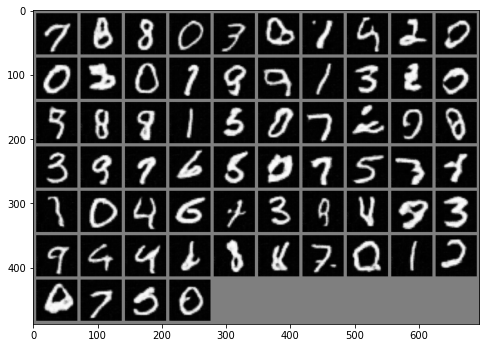

In [ ]:
plt.ion()
generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

    # sample latent vectors from the standard normal distribution here gaussian noise
    fake_image_batch = generator(fixed_noise)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    plt.show()